# Data Pipeline

### Our pipeline process:
#### Extract Features:
- `Airport_Pair` which will be used for `Delay_Trend_Past_Week` to see if there was a Delay trend in the previous week
- `Same_Day_Tail_Reuse`which will be using **ONLY** the date from `dep_datetime`, as well as using `Tail_Number`
- `Previous_Flight_Delay` which will be using information from `Tail_Number`, `dep_date` which will derive from `dep_datetime`, and `CRSDepTime`
- `Turnaround_Time` will also be extracted from `CRSDepTime` subtracted by `Previous_Arrival_Time`(Which is derived from `Tail_Number`, `dep_date`, and `CRSArrTime`)
- `Slack_Time` that derives from `CRSArrTime` subtracted by `CRSElaspedTime`

#### Outlier
- `Aircraft_Age` outlier must be removed 

#### Transformations: 
- `log_distance` using the log transformation 

#### Drop 
- is_Holidays

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(transform_output = "pandas")

In [2]:
def stratified_random_split(df: pd.DataFrame, target_column: str, test_size: float = 0.1, random_state: int = 42):
    """
    Performs a stratified random train-test split to ensure all classes in 
    'Flight_Status' are proportionally represented in both sets.

    Parameters:
    df (pd.DataFrame): The dataset containing the target variable.
    target_column (str): The column representing the classification target.
    test_size (float): The proportion of data to be used as test data.
    random_state (int): Random seed for reproducibility.

    Returns:
    tuple: (train_df, test_df) DataFrames.
    """
    train_df, test_df = train_test_split(
        df, test_size=test_size, stratify=df[target_column], random_state=random_state
    )

    print(f"Train size: {len(train_df)} samples")
    print(f"Test size: {len(test_df)} samples")

    return train_df, test_df

In [3]:
# Setting up the DataFrame for the flight data
flight_data = pd.read_parquet("data/WEATHER.parquet")

# Stratify the data
train_data, test_data= stratified_random_split(flight_data, target_column="Flight_Status")

Train size: 13184010 samples
Test size: 1464890 samples


In [4]:
# downsampling the data 
train_data = train_data.sample(n=100000, random_state=42)

# Splitting the data into X and y
X = train_data.drop(columns=["Flight_Status"])
y = train_data["Flight_Status"]

### Pipeline Functions

In [11]:
class DelayTrendEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer that precomputes a route-based delay trend table using the training set,
    then merges it into any dataset based on (day_of_year, origin, dest).
    This allows for valid use in future (unlabeled) prediction data.

    Parameters:
        date_col (str): Name of the datetime column
        origin_col (str): Column name for origin airport ID
        dest_col (str): Column name for destination airport ID
        status_col (str): Target column used to derive delay signal (only during fit)
        output_col (str): Name of the output trend feature
    """

    def __init__(self,
                 date_col='dep_datetime',
                 origin_col='OriginAirportID',
                 dest_col='DestAirportID',
                 status_col='Flight_Status',
                 output_col='Delay_Trend'):
        self.date_col = date_col
        self.origin_col = origin_col
        self.dest_col = dest_col
        self.status_col = status_col
        self.output_col = output_col

    def fit(self, X, y=None):
        X = X.copy()
        X[self.date_col] = pd.to_datetime(X[self.date_col])
        X['day_of_year'] = X[self.date_col].dt.dayofyear
        X['Flight_Status'] = y.reset_index(drop=True)

        delay_reasons = [
            'CarrierDelay', 'WeatherDelay', 'NASDelay',
            'SecurityDelay', 'LateAircraftDelay'
        ]

        X['delay_signal'] = 0
        for idx, status in enumerate(X['Flight_Status']):
            if isinstance(status, str) and 'Delay' in status:
                delay_type = status.split(' - ')[-1]
                if delay_type in delay_reasons:
                    X.at[idx, 'delay_signal'] = 1

        trend_table = (
            X.groupby(['day_of_year', self.origin_col, self.dest_col])['delay_signal']
             .mean()
             .reset_index()
             .rename(columns={'delay_signal': self.output_col})
        )

        self.trend_lookup_ = trend_table
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_col] = pd.to_datetime(X[self.date_col])
        X['day_of_year'] = X[self.date_col].dt.dayofyear

        X = X.merge(
            self.trend_lookup_,
            on=['day_of_year', self.origin_col, self.dest_col],
            how='left'
        )

        X[self.output_col] = X[self.output_col].fillna(0)
        return X.drop(columns=['day_of_year'])

class SameDayTailReuseEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer that creates a feature counting how many times
    the same tail number (aircraft) is used on the same day.

    Parameters:
        datetime_col (str): Column containing full departure datetime
        tail_col (str): Column name for tail number
        output_col (str): Name of the output column
    """

    def __init__(self,
                 datetime_col='dep_datetime',
                 tail_col='Tail_Number',
                 output_col='Same_Day_Tail_Reuse'):
        self.datetime_col = datetime_col
        self.tail_col = tail_col
        self.output_col = output_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Ensure datetime is parsed correctly
        X[self.datetime_col] = pd.to_datetime(X[self.datetime_col])

        # Extract just the date portion
        X['dep_date'] = X[self.datetime_col].dt.date

        # Count reuse of same tail number per day
        X[self.output_col] = (
            X.groupby([self.tail_col, 'dep_date'])[self.tail_col]
            .transform('count')
            .astype(float)  
        )

        return X.drop(columns=['dep_date'])

    
class TurnaroundDelayEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer that computes:
    - Previous_Flight_Delay: scheduled departure time of previous flight with same tail number on same day
    - Turnaround_Time: time between previous arrival and current departure

    Parameters:
        datetime_col (str): Column with full departure datetime
        dep_time_col (str): Column with scheduled departure time (e.g. CRSDepTime)
        arr_time_col (str): Column with scheduled arrival time (e.g. CRSArrTime)
        tail_col (str): Tail number column
        output_prefix (str): Prefix to use for new feature columns
    """

    def __init__(self,
                 datetime_col='dep_datetime',
                 dep_time_col='CRSDepTime',
                 arr_time_col='CRSArrTime',
                 tail_col='Tail_Number',
                 output_prefix=''):
        self.datetime_col = datetime_col
        self.dep_time_col = dep_time_col
        self.arr_time_col = arr_time_col
        self.tail_col = tail_col
        self.output_prefix = output_prefix

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.datetime_col] = pd.to_datetime(X[self.datetime_col])
        X['dep_date'] = X[self.datetime_col].dt.date

        # Sort the values
        X = X.sort_values(by=[self.tail_col, 'dep_date', self.dep_time_col])

        prev_delay_col = self.output_prefix + 'Previous_Flight_Delay'
        turnaround_col = self.output_prefix + 'Turnaround_Time'

        # Previous scheduled departure
        X[prev_delay_col] = (
            X.groupby([self.tail_col, 'dep_date'])[self.dep_time_col]
            .shift(1)
        )

        # Previous scheduled arrival time
        X['Previous_Arrival_Time'] = (
            X.groupby([self.tail_col, 'dep_date'])[self.arr_time_col]
            .shift(1)
        )

        # Compute turnaround time using a defined method
        X[turnaround_col] = self._calculate_turnaround(X[self.dep_time_col], X['Previous_Arrival_Time'])

        # Replace missing with 0
        X[prev_delay_col] = X[prev_delay_col].fillna(0)
        X[turnaround_col] = X[turnaround_col].fillna(0)

        return X.drop(columns=['dep_date', 'Previous_Arrival_Time'])

    def _calculate_turnaround(self, current_dep, previous_arr):
        """
        Applies time difference logic with wrap-around at midnight (2400).
        """
        diff = current_dep - previous_arr
        adjusted = diff.mask((~diff.isna()) & (diff < 0), diff + 2400)
        return adjusted

class SlackTimeEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer that calculates slack time as the difference between scheduled
    arrival time (CRSArrTime) and scheduled elapsed time (CRSElapsedTime).

    Parameters:
        arr_col (str): Column name for scheduled arrival time.
        elapsed_col (str): Column name for scheduled elapsed time.
        output_col (str): Name of the output column to store slack time.
    """

    def __init__(self,
                 arr_col='CRSArrTime',
                 elapsed_col='CRSElapsedTime',
                 output_col='Slack_Time'):
        self.arr_col = arr_col
        self.elapsed_col = elapsed_col
        self.output_col = output_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.output_col] = X[self.arr_col] - X[self.elapsed_col]
        return X

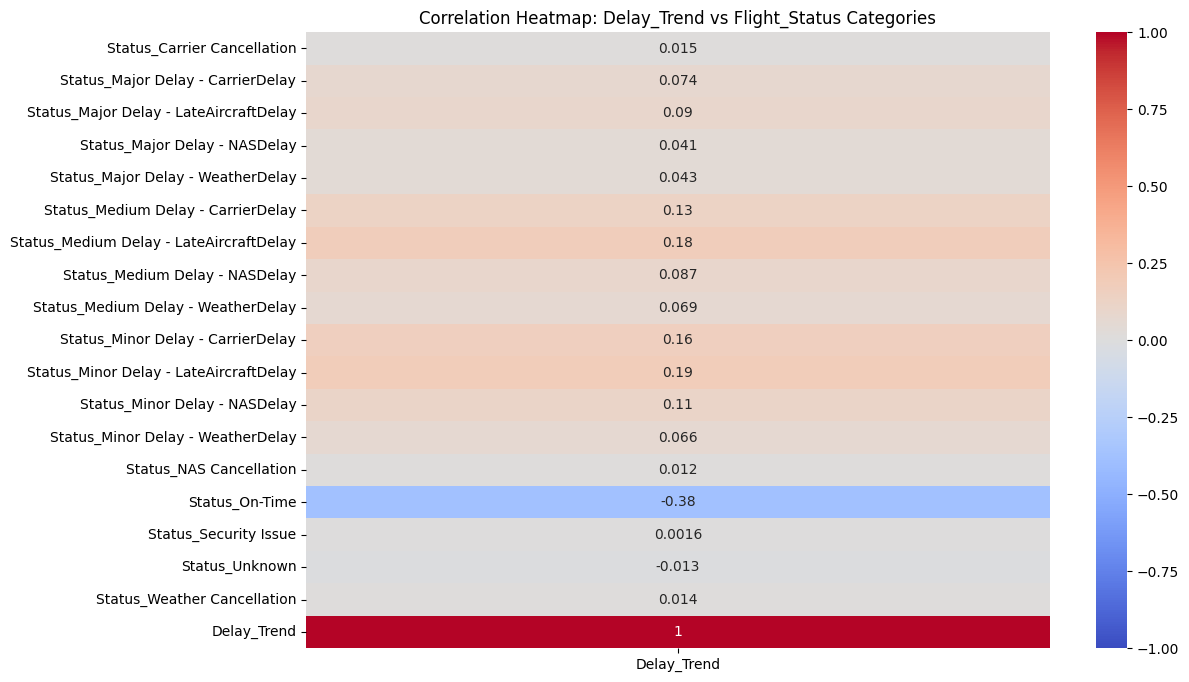

In [12]:
# Apply the fitted DelayTrendEncoder to the data
encoder = DelayTrendEncoder(
    date_col='dep_datetime',
    origin_col='OriginAirportID',
    dest_col='DestAirportID',
    status_col='Flight_Status',
    output_col='Delay_Trend'
)

# Fit on data using target label
encoder.fit(flight_data, flight_data['Flight_Status'])

# Transform the data
data_transformed = encoder.transform(flight_data)

# Create dummy variables for Flight_Status categories
status_dummies = pd.get_dummies(flight_data['Flight_Status'], prefix='Status')

# Add trend feature to the dummy DataFrame
correlation_df = pd.concat([status_dummies, data_transformed[['Delay_Trend']]], axis=1)

# Calculate correlation matrix
correlation_matrix = correlation_df.corr()

# Plot heatmap for Delay_Trend against all status categories
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['Delay_Trend']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Delay_Trend vs Flight_Status Categories')
plt.show()


### Pipeline Model

In [13]:
numerical_features = [
    'Distance', 'relative_humidity_2m', 'temperature_2m',
    'Delay_Trend', 'Same_Day_Tail_Reuse', 'Previous_Flight_Delay',
    'Turnaround_Time', 'Slack_Time',
    'Aircraft_Seats', 'Aircraft_Engines', 'Aircraft_Age', 'Is_Freighter',
    'Is_Holiday_Week',
    'temperature_2m_dest_dep_time', 'relative_humidity_2m_dest_dep_time',
    'precipitation', 'showers', 'snowfall', 'snow_depth',
    'soil_moisture_0_to_1cm', 'et0_fao_evapotranspiration', 'evapotranspiration',
    'cloud_cover_high', 'cloud_cover_low', 'surface_pressure', 'weather_code',
    'pressure_msl', 'wind_direction_10m', 'wind_gusts_10m',
    'precipitation_dest_dep_time', 'showers_dest_dep_time',
    'snowfall_dest_dep_time', 'snow_depth_dest_dep_time',
    'soil_moisture_0_to_1cm_dest_dep_time',
    'et0_fao_evapotranspiration_dest_dep_time',
    'evapotranspiration_dest_dep_time', 'cloud_cover_high_dest_dep_time',
    'cloud_cover_low_dest_dep_time', 'surface_pressure_dest_dep_time',
    'weather_code_dest_dep_time', 'pressure_msl_dest_dep_time',
    'wind_direction_10m_dest_dep_time', 'wind_gusts_10m_dest_dep_time'
]

numeric_transformer = Pipeline(steps=[
    ('log1p_distance', ColumnTransformer([
        ('log', FunctionTransformer(np.log1p), ['Distance'])
    ], remainder='passthrough', verbose_feature_names_out=False)),
    
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = Pipeline([
    ('delay_trend', DelayTrendEncoder(
        date_col='dep_datetime',
        origin_col='OriginAirportID',
        dest_col='DestAirportID',
        status_col='Flight_Status',
        output_col='Delay_Trend'
    )),
    ('tail_reuse', SameDayTailReuseEncoder(
        datetime_col='dep_datetime',
        tail_col='Tail_Number',
        output_col='Same_Day_Tail_Reuse'
    )),
    ('turnaround_delay', TurnaroundDelayEncoder(
        datetime_col='dep_datetime',
        dep_time_col='CRSDepTime',
        arr_time_col='CRSArrTime',
        tail_col='Tail_Number',
        output_prefix=''
    )),
    ('slack_time', SlackTimeEncoder(
        arr_col='CRSArrTime',
        elapsed_col='CRSElapsedTime',
        output_col='Slack_Time'
    )),
    ('feature_prep', ColumnTransformer([
        ('numeric', numeric_transformer, numerical_features),
        ('drop', 'drop', [
            'Aircraft_Model', 'Aircraft_EngineType', 'Holiday',
            'dest_dep_datetime', 'dep_datetime', 'Tail_Number'
        ])
    ], remainder='passthrough', verbose_feature_names_out=False)),
    # ('select', SelectFromModel(ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)))
])

preprocessor

Pipeline(steps=[('delay_trend', DelayTrendEncoder()),
                ('tail_reuse', SameDayTailReuseEncoder()),
                ('turnaround_delay', TurnaroundDelayEncoder()),
                ('slack_time', SlackTimeEncoder()),
                ('feature_prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('log1p_distance',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('lo...
                                                   'et0_fao_evapotranspiration',
                                                   'evapotranspiration',
                                                   'cloud_cover_high',
                                                   'cloud_cover_low',
                                                   'surface_pressure',
                                                   'weather_code',
                                                   'pressure_msl',
                                                   'wind_direction_10m',
                                                   'wind_gusts_10m',
                                                   'precipitation_dest_dep_time', ...]),
                                                 ('drop', 'drop',
                                                  ['Aircraft_Model',
                                                   'Aircraft_EngineType',
                                                   'Holiday',
                                                   'dest_dep_datetime',
                                                   'dep_datetime',
                                                   'Tail_Number'])],
                                   verbose_feature_names_out=False))])

In [14]:
# Train the pipeline in this cell and run it on X, this cell must end with the transformed data
X_prepped = preprocessor.fit_transform(X, y)
# X_prepped = preprocessor.fit_transform(X, y)
pd.set_option('display.max_columns', None)
X_prepped

,Distance,relative_humidity_2m,temperature_2m,Delay_Trend,Same_Day_Tail_Reuse,Previous_Flight_Delay,Turnaround_Time,Slack_Time,Aircraft_Seats,Aircraft_Engines,Aircraft_Age,Is_Freighter,Is_Holiday_Week,temperature_2m_dest_dep_time,relative_humidity_2m_dest_dep_time,precipitation,showers,snowfall,snow_depth,soil_moisture_0_to_1cm,et0_fao_evapotranspiration,evapotranspiration,cloud_cover_high,cloud_cover_low,surface_pressure,weather_code,pressure_msl,wind_direction_10m,wind_gusts_10m,precipitation_dest_dep_time,showers_dest_dep_time,snowfall_dest_dep_time,snow_depth_dest_dep_time,soil_moisture_0_to_1cm_dest_dep_time,et0_fao_evapotranspiration_dest_dep_time,evapotranspiration_dest_dep_time,cloud_cover_high_dest_dep_time,cloud_cover_low_dest_dep_time,surface_pressure_dest_dep_time,weather_code_dest_dep_time,pressure_msl_dest_dep_time,wind_direction_10m_dest_dep_time,wind_gusts_10m_dest_dep_time,Year,Quarter,Month,DayofMonth,DayOfWeek,DOT_ID_Operating_Airline,Flight_Number_Operating_Airline,OriginAirportID,OriginCityMarketID,OriginStateFips,DestAirportID,DestCityMarketID,DestStateFips,CRSDepTime,CRSArrTime,CRSElapsedTime
96837,0.812697,0.849713,0.455950,-0.006325,-0.138096,-0.111810,-0.084207,-0.707805,5.357594e-16,0.0,0.0,0.0,-0.453852,-0.858864,-1.105517,-0.057736,-0.024313,-0.044381,-0.095411,-0.826704,-0.372553,-0.12808,-0.380579,-0.474714,0.592864,-0.344243,-0.218842,-0.703014,1.662755,-0.069738,-0.022545,-0.045935,-0.093644,0.803794,-0.369373,-0.122604,2.638986,-0.792515,0.163987,-0.173319,-0.097231,-0.146259,1.874713,2024,1,3,26,2,20368,887.0,14082,34082,12,12265,32265,36,900,1153,173.0
61316,-0.097148,1.071660,-0.030043,-0.006325,-0.138096,-0.111810,-0.084207,1.253605,5.357594e-16,0.0,0.0,0.0,-0.453852,0.257159,-0.528854,-0.057736,-0.024313,-0.044381,-0.095411,0.665210,-0.696133,-0.12808,-0.475126,1.654496,0.093661,-0.172696,-0.787199,-0.713295,0.752464,-0.069738,-0.022545,-0.045935,-0.093644,0.163482,0.397515,-0.122604,-0.471763,-0.792515,-0.185782,-0.343991,-1.175780,-0.805114,0.171060,2024,2,5,13,1,20368,3182.0,10693,30693,47,10408,30408,55,1923,2111,108.0
19493,0.485438,0.805323,0.017238,-0.006325,-0.138096,-0.111810,-0.084207,-0.326260,5.357594e-16,0.0,0.0,0.0,-0.453852,0.124340,-0.085267,-0.057736,-0.024313,-0.044381,-0.095411,-1.320715,-0.141876,-0.12808,-0.475126,0.748970,-3.179846,-0.229878,-0.679672,-0.688500,-0.339884,-0.069738,-0.022545,-0.045935,-0.093644,1.168280,0.503147,-0.122604,-0.471763,-0.792515,-0.147160,-0.343991,-0.867623,0.927941,1.935557,2024,2,6,9,7,20368,1561.0,11292,30325,8,10408,30408,55,959,1317,138.0
94014,0.708460,-0.481971,0.382397,-0.006325,-0.138096,-0.111810,-0.084207,0.557621,5.357594e-16,0.0,0.0,0.0,-0.453852,1.351586,0.447038,-0.057736,-0.024313,-0.044381,-0.095411,-0.530297,1.003497,-0.12808,-0.475126,-0.768398,0.219698,-0.344243,1.286537,1.552452,-0.704001,-0.069738,-0.022545,-0.045935,-0.093644,-0.279811,1.210014,-0.122604,-0.471763,-0.157397,0.629552,5.060614,-0.035600,-1.108787,-0.285275,2024,4,10,4,5,20368,583.0,11986,31986,26,14112,33195,12,1520,1804,164.0
86433,0.781669,0.317039,0.581310,-0.006325,-0.138096,-0.111810,-0.084207,-0.345433,5.357594e-16,0.0,0.0,0.0,2.203361,-0.443682,-0.129625,-0.057736,-0.024313,-0.044381,-0.095411,-1.004548,-0.450829,-0.12808,-0.475126,-0.792872,0.308382,-0.344243,0.288071,1.467809,-0.916402,-0.069738,-0.022545,-0.045935,-0.093644,-0.634445,-0.298378,-0.122604,-0.471763,-0.792515,0.097444,-0.343991,0.519083,1.168547,0.079793,2024,4,10,7,1,20368,541.0,10423,30423,48,11986,31986,26,949,1329,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38954,0.863614,-0.481971,-0.163964,-0.006325,-0.138096,-0.111810,-0.084207,-0.521826,5.357594e-16,0.0,0.0,0.0,2.203361,-2.453329,-0.307060,-0.057736,-0.024313,-0.044381,-0.095411,-1.409637,-0.487099,-0.12808,2.392808,-0.7

In [ ]:
# # pickle the preprocessor
# import pickle
# with open("preprocessor.pkl", "wb") as f:
#     pickle.dump(preprocessor, f, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# use MLP classifier on the pipeline

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, f1_score

X_test = test_data.drop('Flight_Status', axis=1)
y_test = test_data['Flight_Status']

# Your X_prepped is already available from previous preprocessing
# Now we'll create and train the MLP classifier optimized for precision

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_score

# Create the MLP classifier with precision-focused parameters
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Two hidden layers
    activation='relu',             
    solver='adam',                 
    alpha=0.001,                   # Higher regularization for better precision
    batch_size='auto',             
    learning_rate='adaptive',      
    max_iter=2000,                 # More iterations to ensure convergence
    early_stopping=True,           # Stop if validation performance doesn't improve
    validation_fraction=0.2,       # Portion of training data used for validation
    n_iter_no_change=20,           # Patience parameter
    random_state=42,
)

# Train the model using your preprocessed X data
mlp.fit(X_prepped, y)

# For testing, you'll need to apply the same preprocessing to X_test
# If you haven't already done this, you would typically do:
# X_test_prepped = preprocessor.transform(X_test)
# But since you didn't specify this step, I'll assume you need to do it:

# Make predictions (using whatever preprocessed test data you have)
# If X_test is already preprocessed:
y_pred = mlp.predict(X_test)
# If you need to preprocess X_test:
# y_pred = mlp.predict(X_test_prepped)

# Evaluate with focus on precision
print("Precision score:", precision_score(y_test, y_pred, average='macro'))
print("F1 score:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ValueError: Input X contains NaN.
MLPClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values